In [5]:
import torch
from torch import nn


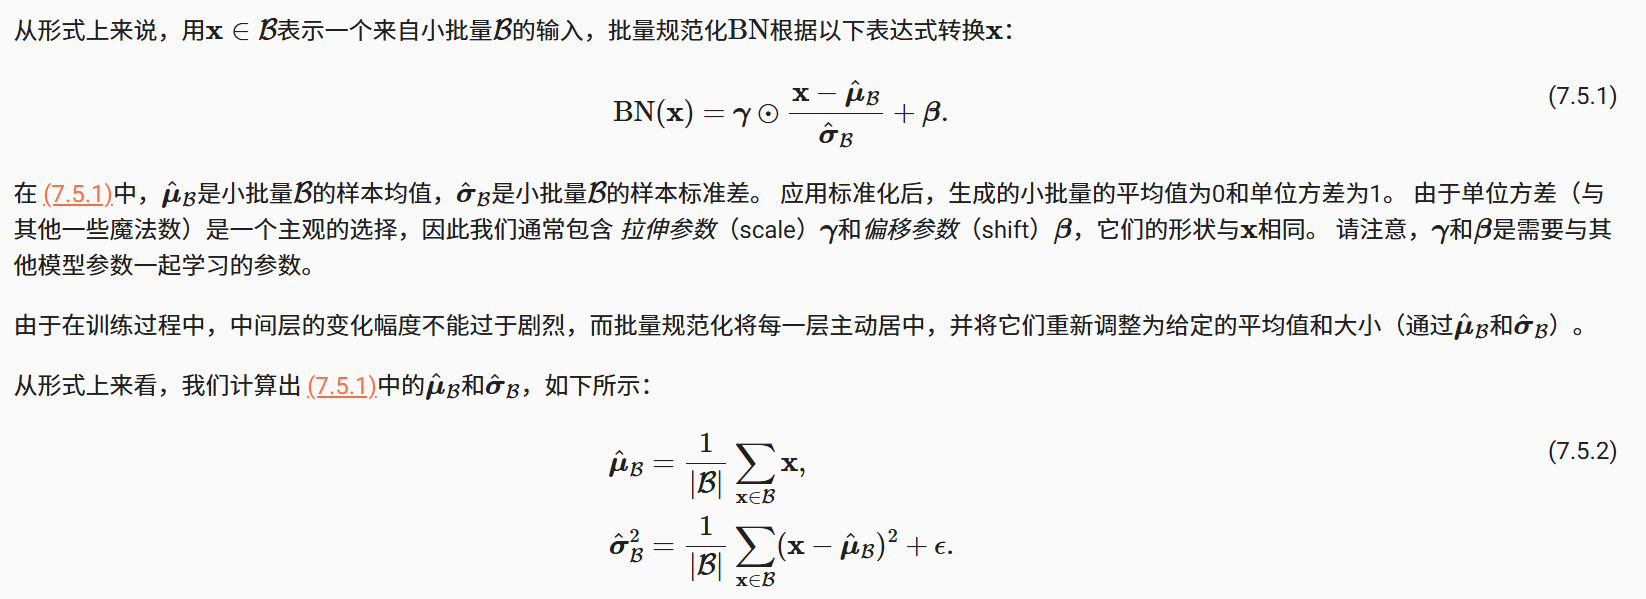

In [6]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    """
    批量规范化

    :param X: 输入数据，形状可以是二维或四维张量
    :param gamma: 缩放参数，形状与X的通道数相同
    :param beta: 平移参数，形状与X的通道数相同
    :param moving_mean: 移动平均的均值，形状与X的通道数相同
    :param moving_var: 移动平均的方差，形状与X的通道数相同
    :param eps: 防止除零的极小值
    :param momentum: 动量参数，用于更新移动平均
    :return: 归一化后的数据Y，以及更新后的移动平均均值和方差
    """
    # 根据是否在训练模式下，选择计算均值和方差还是使用移动平均
    if not torch.is_grad_enabled():
        # 在预测模式下，使用传入的移动平均进行归一化
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)  # 确保输入是二维或四维张量
        # 如果是2维张量，计算均值和方差
        if len(X.shape) == 2: # 此时使用全连接层
            mean = X.mean(dim=0)
            var = ((X  - mean) ** 2 ).mean(dim=0)
        else:  # 如果是二维卷积层，计算通道维dim=1上的均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 在训练模式下，使用当前批次的均值和方差进行归一化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var
    # 进行缩放和移位
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data


In [7]:
class BatchNorm(nn.Module):
    """
    批量规范化层
    """
    def __init__(self, num_features, num_dims):
        """
        初始化批量规范化层

        :param num_features: 特征数量，对于二维张量是输出的维度，对于四维张量是通道数
        :param num_dims: 输入数据的维度，2表示全连接层，4表示卷积层
        """
        super().__init__()
        self.num_features = num_features
        if num_dims == 2:
            shape = (1, num_features)  # 全连接层的参数形状
        else:
            shape = (1, num_features, 1, 1)  # 卷积层的参数形状
        # 初始化缩放参数gamma和平移参数beta
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 初始化移动平均的均值和方差
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self,X):
        """
        前向传播

        :param X: 输入数据
        :return: 归一化后的数据
        """
        if self.moving_var.device != X.device:
            # 确保移动平均的均值和方差与输入数据在同一设备上
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 调用batch_norm函数进行批量规范化
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9
        )
        return Y

In [9]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

2025-08-19 18:35:56,041 - INFO - NumExpr defaulting to 16 threads.


training on cuda:0
epoch 1, loss 0.729, train acc 0.737, test acc 0.789
epoch 2, loss 0.467, train acc 0.829, test acc 0.763
epoch 3, loss 0.395, train acc 0.857, test acc 0.769
epoch 4, loss 0.361, train acc 0.869, test acc 0.847
epoch 5, loss 0.334, train acc 0.878, test acc 0.853
epoch 6, loss 0.313, train acc 0.886, test acc 0.866
epoch 7, loss 0.301, train acc 0.889, test acc 0.849
epoch 8, loss 0.288, train acc 0.894, test acc 0.827
epoch 9, loss 0.278, train acc 0.898, test acc 0.871
epoch 10, loss 0.267, train acc 0.901, test acc 0.842


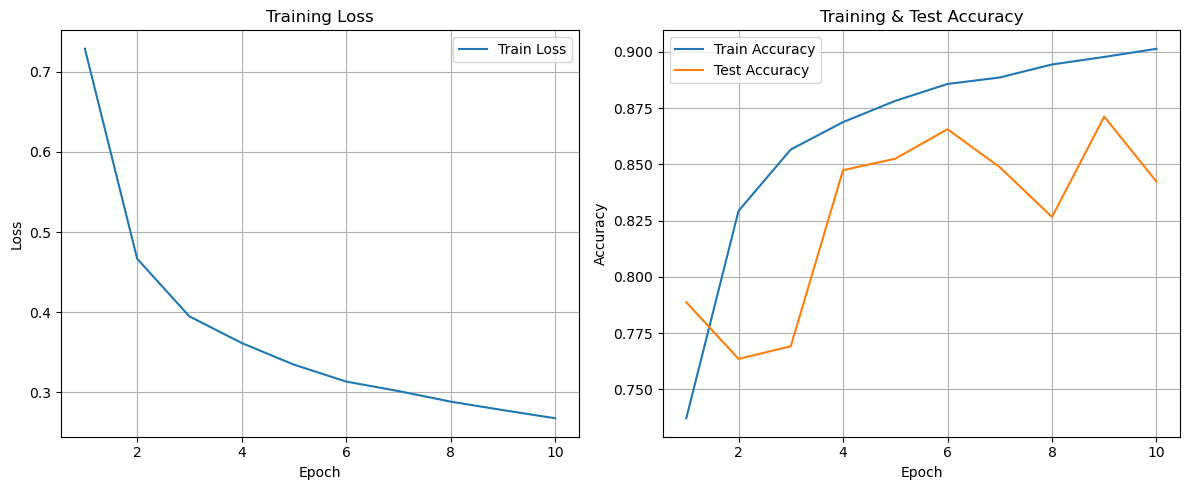

loss 0.267, train acc 0.901, test acc 0.842


In [10]:
import traintools
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = traintools.load_data_fashion_mnist(batch_size)
traintools.train_ch6(net, train_iter, test_iter, num_epochs, lr, traintools.try_gpu())

In [13]:
net[1].gamma.reshape((-1,)).data, net[1].beta.reshape((-1,)).data, \
net[1].moving_mean.reshape((-1,)).data, net[1].moving_var


(tensor([2.0424, 2.7023, 2.4609, 3.7070, 3.2351, 2.7829], device='cuda:0'),
 tensor([ 0.9393,  2.7822,  2.9426, -2.5745,  1.7585,  0.4428], device='cuda:0'),
 tensor([ 0.3288,  0.7314,  1.5978, -0.2123,  0.2850,  0.2180], device='cuda:0'),
 tensor([[[[0.3690]],
 
          [[0.6787]],
 
          [[1.8057]],
 
          [[1.3464]],
 
          [[1.0323]],
 
          [[1.1150]]]], device='cuda:0'))

In [15]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

training on cuda:0
epoch 1, loss 0.754, train acc 0.728, test acc 0.720
epoch 2, loss 0.479, train acc 0.823, test acc 0.726
epoch 3, loss 0.409, train acc 0.852, test acc 0.773
epoch 4, loss 0.368, train acc 0.866, test acc 0.749
epoch 5, loss 0.342, train acc 0.875, test acc 0.843
epoch 6, loss 0.319, train acc 0.883, test acc 0.831
epoch 7, loss 0.304, train acc 0.889, test acc 0.836
epoch 8, loss 0.291, train acc 0.893, test acc 0.858
epoch 9, loss 0.284, train acc 0.895, test acc 0.880
epoch 10, loss 0.271, train acc 0.900, test acc 0.574


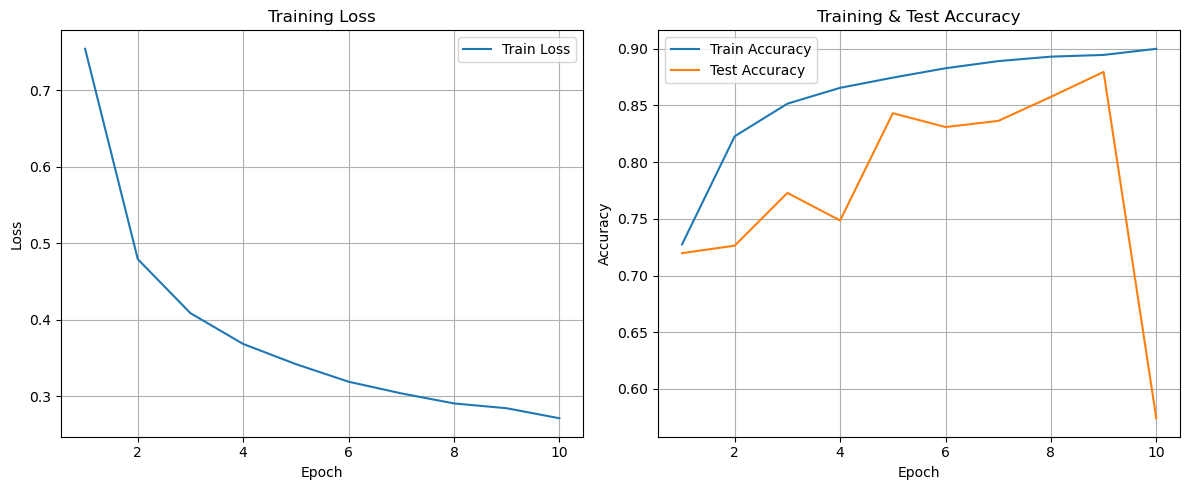

loss 0.271, train acc 0.900, test acc 0.574


In [16]:
traintools.train_ch6(net, train_iter, test_iter, num_epochs, lr, traintools.try_gpu())